In [1]:
project_name="anime-dcgan"

### Get Dataset

In [2]:
# import opendatasets as od
# dataset_url = "https://www.kaggle.com/splcher/animefacedataset"
# od.download(dataset_url)

In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5,0.5),(0.5,0.5,0.5) #normallize RGB to 0.5

In [5]:
train_ds = ImageFolder(root='./animefacedataset',transform=T.Compose([
  T.Resize(image_size), #resize to 64x64
  T.CenterCrop(image_size), #center crop to 64x64
  T.ToTensor(), #convert to tensor
  T.Normalize(*stats)])) #normalize to 0.5 from (0,1) to (-1,1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensor):
  """take image_tensor multiply with standard deviation and add the mean value. Bring it back to (0,1)"""
  return img_tensor * stats[0][1] + stats[0][0]

In [8]:
def show_image(image, nmax=64):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(image.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl,nmax=64):
  for images, _ in dl:
    show_image(images,nmax=nmax)
    break

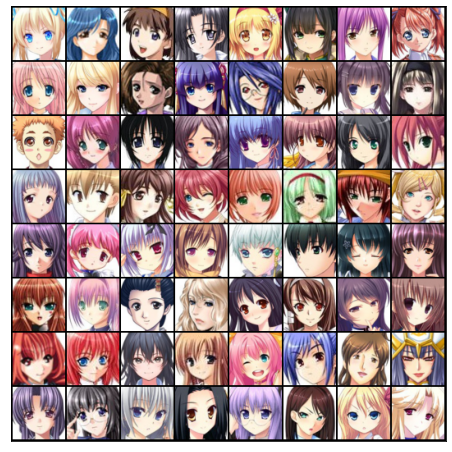

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
  """Pick GPU if possible else CPU"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data,device):
  """move tensor to chosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  """Wrap DataLoader to device"""
  def __init__(self,dl,device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b,self.device)

  def __len__(self):
    """number of batches"""
    return len(self.dl)



In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl,device)

### Discriminator Network

In [13]:
# Classifier model (DCGAN)
import torch.nn as nn

discriminator = nn.Sequential(
  # input is 3 x 64 x 64
  nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(64),
  nn.LeakyReLU(0.2,inplace=True),
  #output is 64 x 32 x 32
  
  nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(128),
  nn.LeakyReLU(0.2,inplace=True),
  #output is 128 x 16 x 16

  nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(256),
  nn.LeakyReLU(0.2,inplace=True),
  #output is 256 x 8 x 8

  nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(512),
  nn.LeakyReLU(0.2,inplace=True),
  #output is 512 x 4 x 4

  nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
  #output is 1 x 1 x 1
  
  nn.Flatten(),
  nn.Sigmoid()  #output is a probability
  # classification use softmax, but generation use sigmoid
)

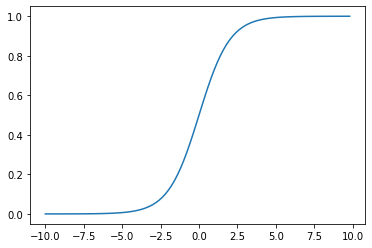

In [14]:
import math
import numpy as np


def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a


x = np.arange(-10., 10., 0.2)
sig = sigmoid(x)
plt.plot(x, sig)
plt.show()


In [15]:
discriminator = to_device(discriminator,device)

In [16]:
latent_size = 128 # controller number, more latent more feature e.g. human face 1024 

In [17]:
generator = nn.Sequential(
  #input: latent_size x 1 x 1
  nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
  nn.BatchNorm2d(512),
  nn.ReLU(inplace=True),
  #output: 512 x 4 x 4

  nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(256),
  nn.ReLU(inplace=True),
  #output: 256 x 8 x 8

  nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(128),
  nn.ReLU(inplace=True),
  #output: 128 x 16 x 16

  nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
  nn.BatchNorm2d(64),
  nn.ReLU(inplace=True),
  #output: 64 x 32 x 32

  nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
  nn.Tanh()
  #output: 3 x 64 x 64
)

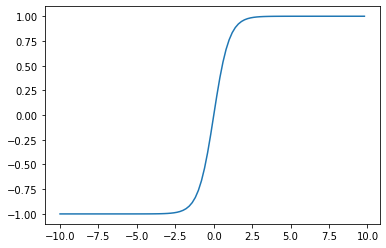

In [18]:
## value from (-1,1)
def tanh(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
tan = tanh(x)
plt.plot(x, tan)
plt.show()

torch.Size([128, 3, 64, 64])


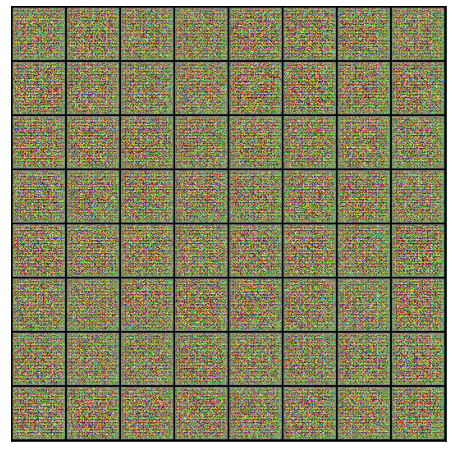

In [19]:
# Create random latent vector
latent = torch.randn(batch_size,latent_size,1,1)
fake_images = generator(latent)
print(fake_images.shape)
show_image(fake_images)

In [20]:
generator = to_device(generator,device)

### Discriminator Network Training

use binary crossentrophy loss

In [21]:
import torch.nn.functional as F

In [22]:
def train_discriminator(real_images, opt_d):
    # clear discriminator gradient
    opt_d.zero_grad()

    # pass real images throgh discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device) #real images always true
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # generate fake Images
    latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_target = torch.zeros(real_images.size(0), 1, device=device) # fake images always false
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_target)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


### Generator Network Training

In [23]:
def train_generator(opt_g):
  # clear generator gradient
  opt_g.zero_grad()

  # generate fake images
  latent = torch.rand(batch_size,latent_size,1,1, device=device)
  fake_images = generator(latent)

  #try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size,1,device=device)
  loss = F.binary_cross_entropy(preds, targets)

  #update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [24]:
from torchvision.utils import save_image
import os
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index,latent_tensors,show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{:04d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
  print("Saving",fake_fname)
  if show:
    fix, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


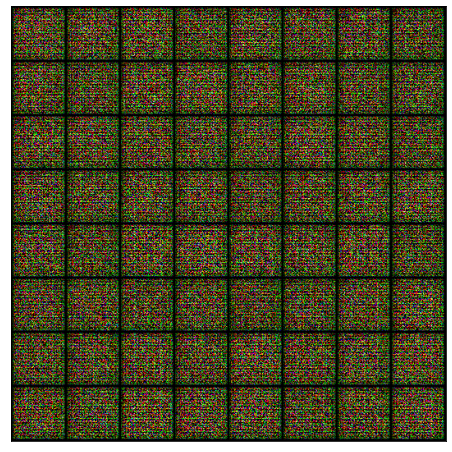

In [27]:
save_samples(0,fixed_latent)

In [28]:
from tqdm.notebook import tqdm

In [32]:
def fit(epochs,lr,start_idx=1):
  torch.cuda.empty_cache()

  #loss and score
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  #Create Optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
  opt_g = torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

  for epoch in range(epochs):
    #Train generator and discriminator
    for real_images, _ in tqdm(train_dl):
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)
    
    #keep record and score
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    #log losses & scorees (last batch)
    print(f"Epoch [{epoch+1}/{epochs}] Loss_D: {loss_d} Loss_G: {loss_g} Real_Score: {real_score} Fake_Score: {fake_score}")

    #save samples
    if (epoch+1) % 10 == 0:
      save_samples(epoch+1,fixed_latent)

  return losses_g, losses_d, real_score, fake_score

In [33]:
lr = 0.0002
epochs = 25

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25] Loss_D: 6.314526399364695e-05 Loss_G: 7.511932926718146e-05 Real_Score: 0.9999597668647766 Fake_Score: 2.2910891857463866e-05


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25] Loss_D: 0.00011005945998476818 Loss_G: 2.8738264518324286e-05 Real_Score: 0.9999102354049683 Fake_Score: 2.005383066716604e-05


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25] Loss_D: 1.2573724234243855e-05 Loss_G: 1.3464229596138466e-05 Real_Score: 0.9999924898147583 Fake_Score: 5.06137121192296e-06


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25] Loss_D: 2.218653025920503e-05 Loss_G: 7.942353477119468e-06 Real_Score: 0.9999821782112122 Fake_Score: 4.256380179867847e-06


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25] Loss_D: 6.28953603154514e-06 Loss_G: 4.8708297981647775e-06 Real_Score: 0.999997615814209 Fake_Score: 3.895035206369357e-06


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25] Loss_D: 2.621065050334437e-06 Loss_G: 3.347179699630942e-06 Real_Score: 0.9999988079071045 Fake_Score: 1.4328260249385494e-06


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25] Loss_D: 4.874589194514556e-06 Loss_G: 2.303163682881859e-06 Real_Score: 0.9999962449073792 Fake_Score: 1.167107484434382e-06


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25] Loss_D: 3.6623046071326826e-06 Loss_G: 1.6829014839458978e-06 Real_Score: 0.9999986886978149 Fake_Score: 2.3485849851567764e-06


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25] Loss_D: 2.2239601094042882e-06 Loss_G: 1.2610116755240597e-06 Real_Score: 0.9999989867210388 Fake_Score: 1.2023699582641711e-06


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [10/25] Loss_D: 8.716226602700772e-07 Loss_G: 9.126966347139387e-07 Real_Score: 0.9999995827674866 Fake_Score: 4.4727792669618793e-07
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25] Loss_D: 1.5868996570134186e-06 Loss_G: 7.944184972075163e-07 Real_Score: 0.9999988079071045 Fake_Score: 4.519810659076029e-07


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25] Loss_D: 5.147679758010781e-07 Loss_G: 5.625190055980056e-07 Real_Score: 0.9999997019767761 Fake_Score: 2.2200345028977608e-07


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25] Loss_D: 3.498875571494864e-07 Loss_G: 4.1630124769653776e-07 Real_Score: 0.9999998211860657 Fake_Score: 8.207305768337392e-08


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25] Loss_D: 2.1751830558969232e-07 Loss_G: 3.008172484442184e-07 Real_Score: 1.0 Fake_Score: 1.2941225691065483e-07


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25] Loss_D: 1.3152206292943447e-06 Loss_G: 2.542511197134445e-07 Real_Score: 0.9999988079071045 Fake_Score: 1.0130663952168106e-07


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25] Loss_D: 1.0217940626944255e-07 Loss_G: 1.9744041424019088e-07 Real_Score: 1.0 Fake_Score: 5.9371664917762246e-08


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25] Loss_D: 1.1069435856825294e-07 Loss_G: 1.4621767263633956e-07 Real_Score: 1.0 Fake_Score: 8.343114643594163e-08


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25] Loss_D: 8.050501776324381e-08 Loss_G: 1.2759122114403e-07 Real_Score: 1.0 Fake_Score: 3.47601698535982e-08


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25] Loss_D: 1.5404336295432586e-07 Loss_G: 1.1548401346317405e-07 Real_Score: 0.9999998807907104 Fake_Score: 7.470752194649322e-08


  0%|          | 0/497 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [20/25] Loss_D: 3.251162894457593e-08 Loss_G: 6.519259443393821e-08 Real_Score: 1.0 Fake_Score: 2.4523505004481194e-08
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25] Loss_D: 2.9415282654099428e-08 Loss_G: 5.02914261346632e-08 Real_Score: 1.0 Fake_Score: 2.181193003991666e-08


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25] Loss_D: 3.0963452246624e-08 Loss_G: 2.7939680791178034e-08 Real_Score: 1.0 Fake_Score: 2.48775435807147e-08


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25] Loss_D: 1.8887752162299876e-07 Loss_G: 1.3969841283767437e-08 Real_Score: 0.9999998807907104 Fake_Score: 3.473090615102592e-08


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25] Loss_D: 3.096345402298084e-09 Loss_G: 6.519258910486769e-09 Real_Score: 1.0 Fake_Score: 7.804757728990808e-09


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25] Loss_D: 2.3996678422122386e-08 Loss_G: 7.450581485102248e-09 Real_Score: 1.0 Fake_Score: 1.1541821720584267e-08


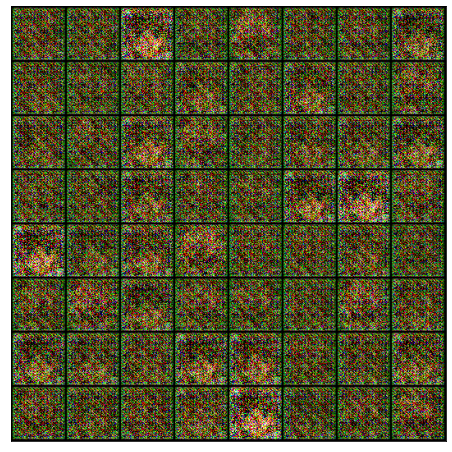

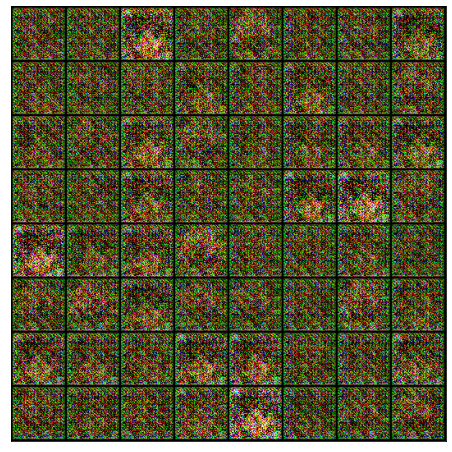

In [34]:
history = fit(epochs, lr)

In [35]:
losses_g, losses_d, real_scores, fake_scores = history

In [36]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [37]:
from IPython.display import Image